<a href="https://colab.research.google.com/github/stephenchen0814/04-LinearReg_Salary/blob/main/Multinomial%20Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import torch
import torch.nn as nn
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.multiclass import OneVsOneClassifier
import pandas as pd
import seaborn as sns


import warnings
warnings.filterwarnings("ignore")

In [3]:
def plot_decision_boundary(X, y, model, resolution=0.02):
    colors = ['red', 'blue', 'lightgreen', 'gray', 'cyan']
    cmap = ListedColormap(colors[:len(np.unique(y))])
    markers = ('s', 'x', 'o', '^', 'v')

    # Set min and max values and give it some padding
    x_min, x_max = X[:,0].min()-1, X[:,0].max()+1
    y_min, y_max = X[:,1].min()-1, X[:,1].max()+1

    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, resolution), np.arange(y_min, y_max, resolution))
    # Predict the function value for the whole grid
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())


    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(X[y==cl, 0], X[y==cl, 1],  color=cmap(idx),edgecolors='k',marker=markers[idx],label=cl)

In [4]:
dataset=datasets.load_iris()
X = dataset.data
y = dataset.target

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
sc=StandardScaler()

X_train=sc.fit_transform(X_train)
X_test=sc.transform(X_test)

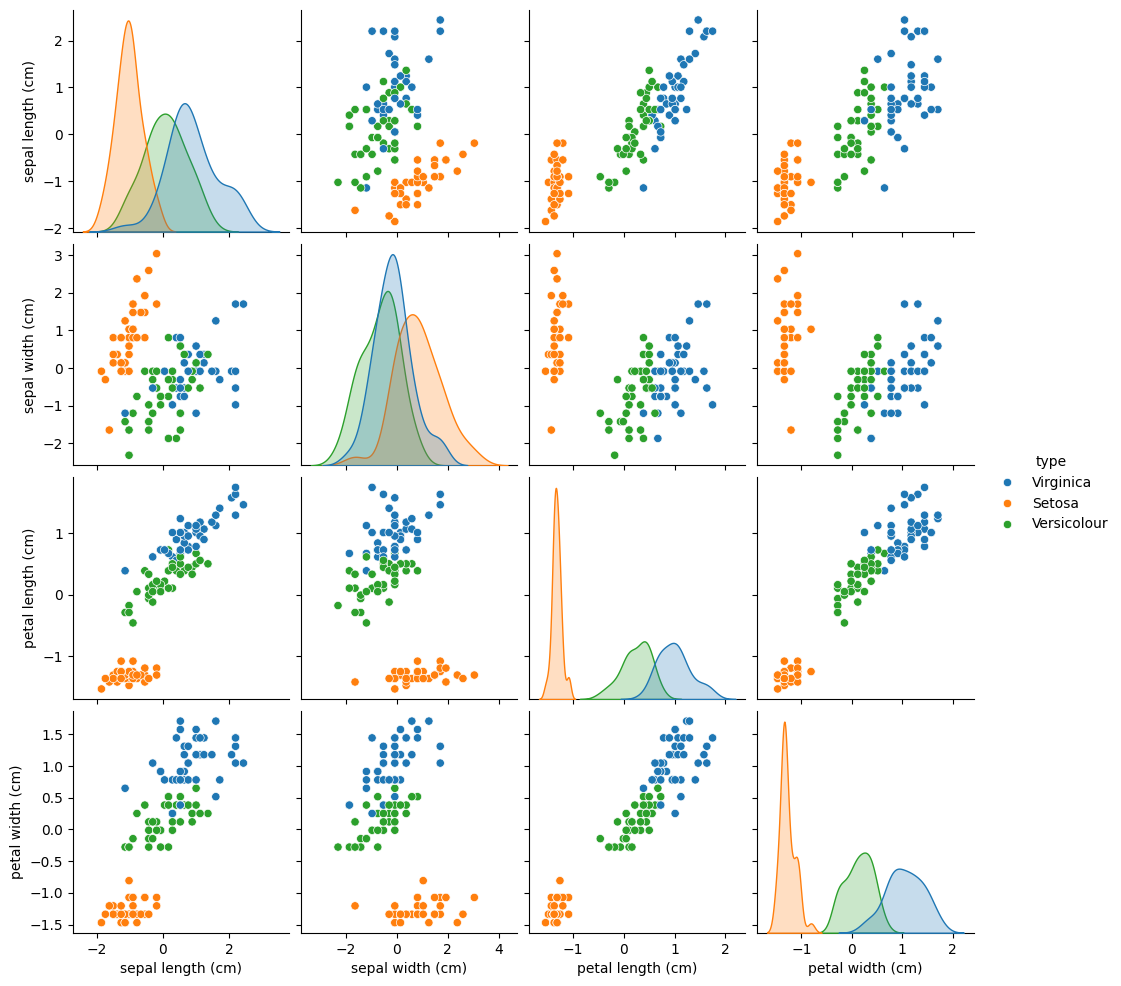

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
sc=StandardScaler()

X_train=sc.fit_transform(X_train)
X_test=sc.transform(X_test)

df = pd.DataFrame(data=X_train, columns=dataset.feature_names)
df['type'] = pd.DataFrame(data=y_train)
label_dict = {0:'Setosa',1:'Versicolour', 2:'Virginica'}
df['type']=df.type.map(label_dict)
sns.pairplot(df, hue="type")
plt.show()

In [7]:
X2_train=X_train[:,[2,3]]
y2_train=y_train
X2_test=X_test[:,[2,3]]
y2_test=y_test

In [8]:
n_samples, n_features = X2_train.shape

lr=0.01
n_epoch=5000

In [9]:
class MultiClassLogisticRegression:

    def __init__(self, n_epoch = 10000, lr=0.01, thres=0.001):
        self.n_epoch = n_epoch
        self.thres = thres
        self.lr=lr
        self.weights=None
        self.bias=None

    def __onehot__(self, y):
        classes = np.unique(y)
        y = np.eye(len(classes))[y]
        return y

    def __softmax__(self, z):
        return np.exp(z) / np.sum(np.exp(z), axis=1).reshape(-1,1)

    def __cross_entropy__(self, a, y):
        return -1 * np.mean(y * np.log(a))

    def __forward__(self, X):
        z=np.dot(X, self.weights)+self.bias
        a=self.__softmax__(z)
        return z,a

    def fit(self, X, y):
        n_class=len(np.unique(y))
        n_samples, n_feat = X.shape
        self.weights= np.zeros(( n_feat, n_class))
        self.bias=np.zeros(n_class)

        for i in range(self.n_epoch):
            y_hot=self.__onehot__(y)

            z, a = self.__forward__(X)

            dw=-np.dot((y_hot-a).T, X).T/X.shape[0]
            db=-(y_hot-a).mean(axis=0)

            if np.abs(dw).max() < self.thres: break

            self.weights = self.weights - self.lr*dw
            self.bias = self.bias - self.lr*db

            loss=np.mean(self.__cross_entropy__(a,y_hot))

            if (i+1)%1000 == 0:
                print(f'Epoch = {(i+1)}:, Loss: {loss:.03f}')


    def predict(self, X):

        _, a=self.__forward__(X)
        return np.argmax(a, axis=1)

    def score(self, X, y):
        return np.mean(self.predict(X) == y)

In [10]:
model= MultiClassLogisticRegression(n_epoch,lr)

In [11]:
model.fit(X2_train, y2_train)

Epoch = 1000:, Loss: 0.126
Epoch = 2000:, Loss: 0.095
Epoch = 3000:, Loss: 0.079
Epoch = 4000:, Loss: 0.069
Epoch = 5000:, Loss: 0.062


In [12]:
print('Weights: ' ,model.weights)
print('bias: ',model.bias)

Weights:  [[-2.26383216  0.28061545  1.98321671]
 [-2.0396449  -0.37120514  2.41085004]]
bias:  [-0.73566082  1.59843142 -0.86277059]


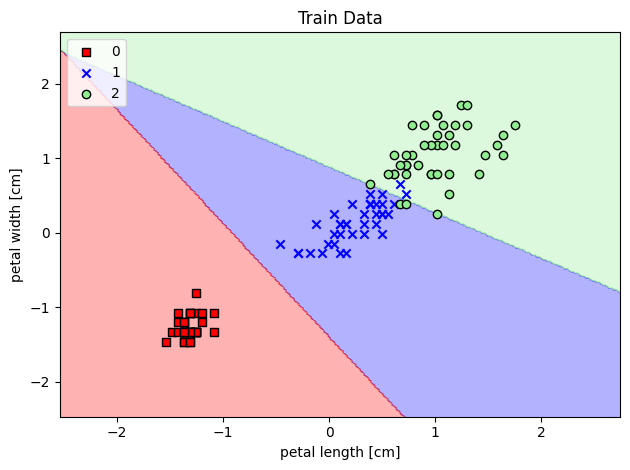

Accuracy =  0.9583333333333334


In [13]:
plot_decision_boundary(X2_train, y2_train, model)
plt.legend(loc='upper left')
plt.title("Train Data")
plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.tight_layout()
plt.show()
print("Accuracy = ", model.score(X2_train, y2_train))

In [14]:
y_train_pred=model.predict(X2_train)
confusion_matrix(y2_train,y_train_pred)

array([[39,  0,  0],
       [ 0, 37,  2],
       [ 0,  3, 39]])

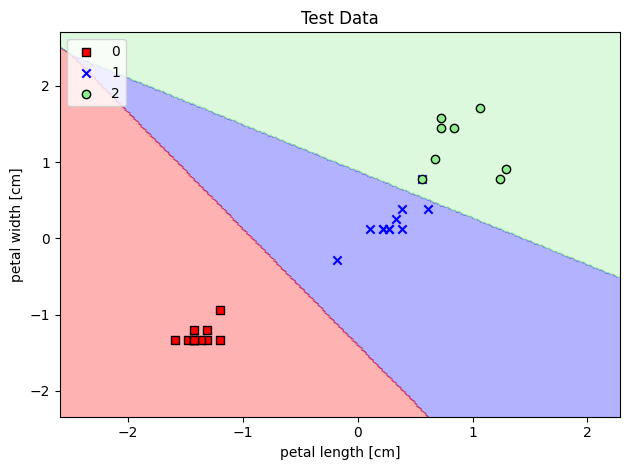

Accuracy =  0.9666666666666667


In [15]:
plot_decision_boundary(X2_test, y2_test, model)
plt.title("Test Data")
plt.legend(loc='upper left')
plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.tight_layout()
plt.show()
print("Accuracy = ", model.score(X2_test, y2_test))

In [16]:
y_test_pred=model.predict(X2_test)
confusion_matrix(y2_test,y_test_pred)

array([[11,  0,  0],
       [ 0, 10,  1],
       [ 0,  0,  8]])

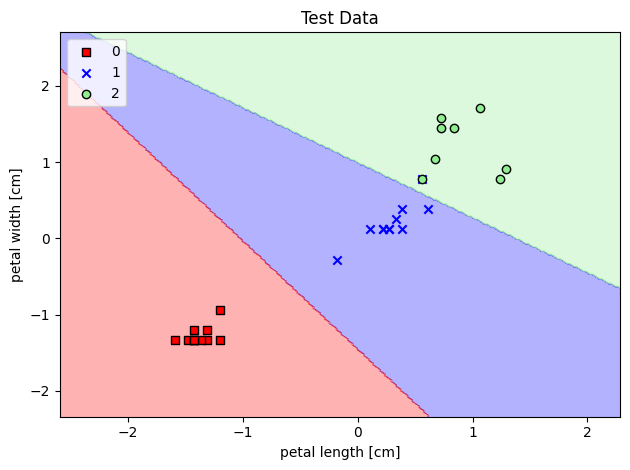

Accuracy =  0.9666666666666667


In [17]:
model = LogisticRegression( solver='sag',multi_class='multinomial', max_iter=n_epoch)
model.fit(X2_train, y2_train)
plot_decision_boundary(X2_test,y2_test,model)
plt.title("Test Data")
plt.legend(loc='upper left')
plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.tight_layout()
plt.show()
print("Accuracy = ", model.score(X2_test, y2_test))

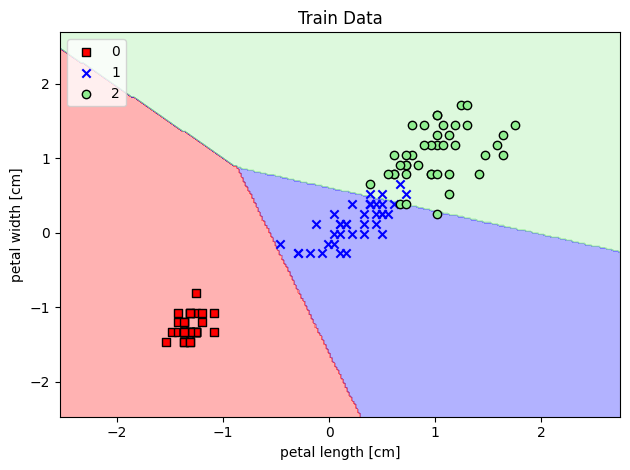

Accuracy =  0.95


In [18]:
model = LogisticRegression( penalty='l2', solver='sag',multi_class='ovr', max_iter=n_epoch)
model.fit(X2_train, y2_train)
plot_decision_boundary(X2_train,y2_train,model)
plt.title("Train Data")
plt.legend(loc='upper left')
plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.tight_layout()
plt.show()
print("Accuracy = ", model.score(X2_train, y2_train))

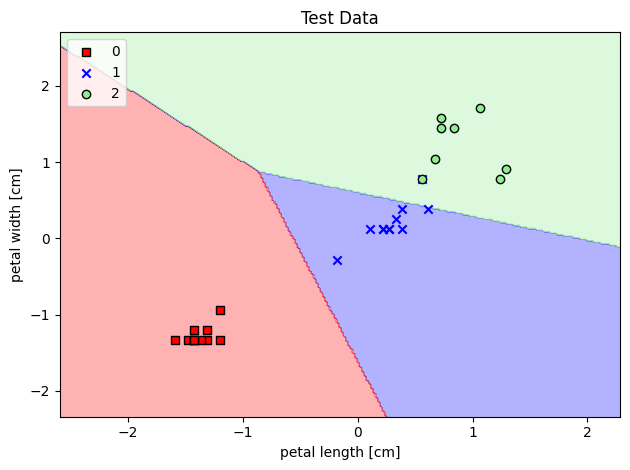

Accuracy =  0.9666666666666667


In [19]:
plot_decision_boundary(X2_test,y2_test,model)
plt.title("Test Data")
plt.legend(loc='upper left')
plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.tight_layout()
plt.show()
print("Accuracy = ", model.score(X2_test, y2_test))

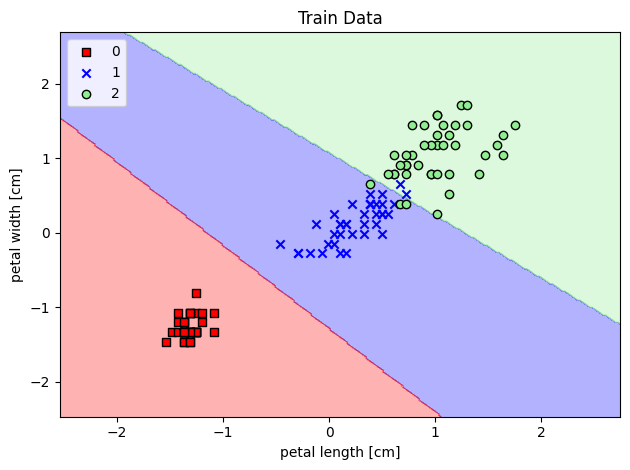

Accuracy =  0.9583333333333334


In [20]:
model = OneVsOneClassifier( LogisticRegression())
model.fit(X2_train, y2_train)
plot_decision_boundary(X2_train,y2_train,model)
plt.title("Train Data")
plt.legend(loc='upper left')
plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.tight_layout()
plt.show()
print("Accuracy = ", model.score(X2_train, y2_train))

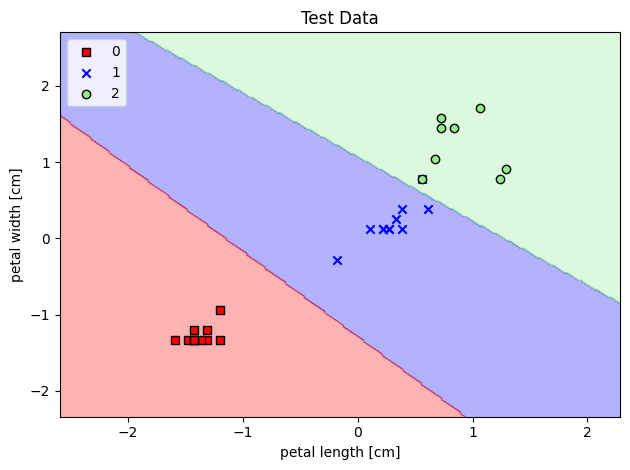

Accuracy =  0.9666666666666667


In [21]:
plot_decision_boundary(X2_test,y2_test,model)
plt.title("Test Data")
plt.legend(loc='upper left')
plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.tight_layout()
plt.show()
print("Accuracy = ", model.score(X2_test, y2_test))

In [22]:
X3_train=torch.tensor(X2_train, dtype=torch.float)
y3_train=torch.tensor(y2_train, dtype=torch.int)
X3_test=torch.tensor(X2_test, dtype=torch.float)
y3_test=torch.tensor(y2_test, dtype=torch.int)

n_samples, n_features = X3_train.shape


lr=0.01
n_epoch=5000
thres=0.001

In [23]:
class MultiClassLogisticRegression(torch.nn.Module):

    def __init__(self, num_features, num_classes):
        super(MultiClassLogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(num_features, num_classes)
        # initialize weights to zeros here,
        # since we used zero weights in the
        # manual approach

        self.linear.weight.detach().zero_()
        self.linear.bias.detach().zero_()
        # Note: the trailing underscore
        # means "in-place operation" in the context
        # of PyTorch

    def forward(self, x):
        logits = self.linear(x)
        probas = nn.Softmax()(logits)
        return logits, probas

model2 = MultiClassLogisticRegression(num_features=n_features, num_classes=3)
optimizer = torch.optim.SGD(model2.parameters(), lr=lr)
lossfunc=nn.CrossEntropyLoss()

In [24]:
def comp_accuracy(true_labels, pred_labels):
    accuracy = torch.sum(true_labels.view(-1).float() ==
                         pred_labels.float()).item() / true_labels.size(0)
    return accuracy



train_loss=[]
test_loss=[]
Time=n_epoch

for epoch in range(n_epoch):

    logits, probas = model2(X3_train)
    loss = lossfunc(logits, y3_train.long())    #nn.CrossEntropyLoss applies softmax already
    optimizer.zero_grad()
    loss.backward()
    train_loss.append(loss.item())
    optimizer.step()


    model2.eval()
    with torch.inference_mode():

        logits, probas = model2(X3_train)
        acc = comp_accuracy(y3_train, torch.argmax(probas, dim=1))

        if (epoch+1)%500 ==0:
            print('Epoch: %03d' % (epoch + 1), end="")
            print(' | Train ACC: %.3f' % acc, end="")
            print(' | Cost: %.3f' % lossfunc(logits, y3_train.long()))
        y_test_pred,_=model2(X3_test)
        lost_test=lossfunc(y_test_pred, y3_test.long())
        test_loss.append(lost_test)

        if np.abs(model2.linear.weight.grad.max()) < thres:
            Time=epoch+1
            break

print('\nModel parameters:')
print('  Weights: %s' % model2.linear.weight)
print('  Bias: %s' % model2.linear.bias)

Epoch: 500 | Train ACC: 0.817 | Cost: 0.477
Epoch: 1000 | Train ACC: 0.942 | Cost: 0.378
Epoch: 1500 | Train ACC: 0.958 | Cost: 0.322
Epoch: 2000 | Train ACC: 0.967 | Cost: 0.284
Epoch: 2500 | Train ACC: 0.967 | Cost: 0.257
Epoch: 3000 | Train ACC: 0.967 | Cost: 0.237
Epoch: 3500 | Train ACC: 0.967 | Cost: 0.220
Epoch: 4000 | Train ACC: 0.958 | Cost: 0.207
Epoch: 4500 | Train ACC: 0.958 | Cost: 0.196
Epoch: 5000 | Train ACC: 0.958 | Cost: 0.187

Model parameters:
  Weights: Parameter containing:
tensor([[-2.2638, -2.0396],
        [ 0.2806, -0.3712],
        [ 1.9832,  2.4109]], requires_grad=True)
  Bias: Parameter containing:
tensor([-0.7357,  1.5984, -0.8628], requires_grad=True)


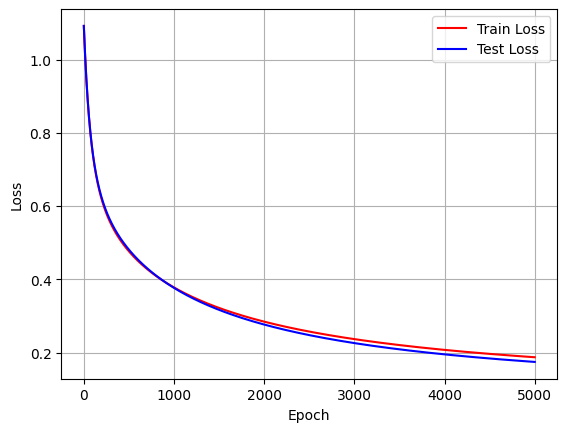

In [25]:
fig=plt.figure()
xv=np.arange(1,Time,1)
plt.plot(xv,train_loss[1:], 'r', label="Train Loss")
plt.plot(xv,test_loss[:-1], 'b', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

In [26]:
def plot_decision_boundary_torch(X, y, classifier, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    tensor = torch.tensor(np.array([xx1.ravel(), xx2.ravel()]).T).float()
    _, probas = classifier.forward(tensor)
    Z = np.argmax(probas.detach().numpy(), axis=1)

    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, color=cmap(idx),
                    edgecolor='black',
                    marker=markers[idx],
                    label=cl)

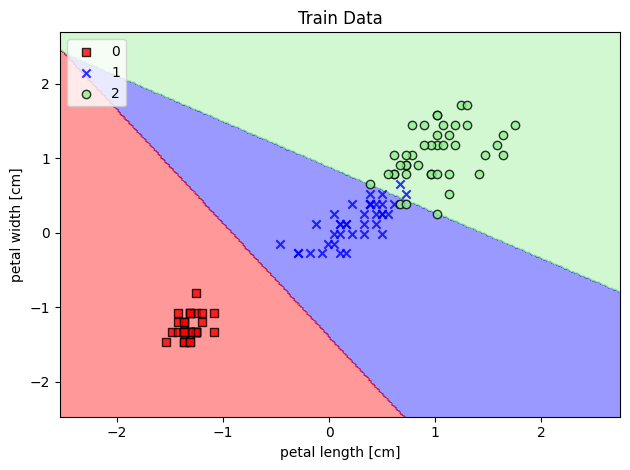

In [27]:
plot_decision_boundary_torch(X3_train, y3_train, classifier=model2)
plt.title("Train Data")
plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

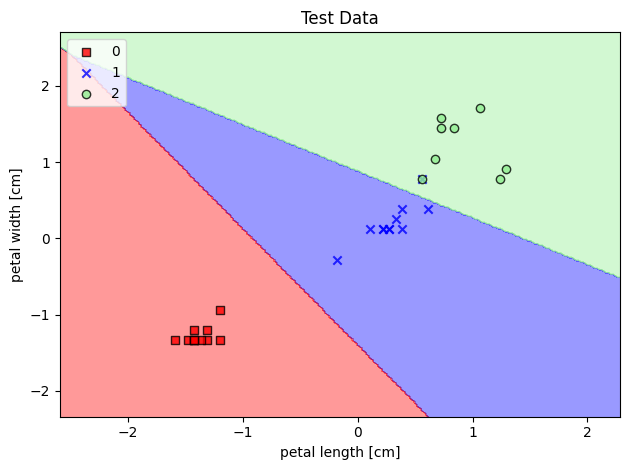

In [28]:
plot_decision_boundary_torch(X3_test, y3_test, classifier=model2)
plt.title("Test Data")
plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()